<a href="https://colab.research.google.com/github/mmaruthi/Deep_Learning_EVA4_Phase1/blob/master/S12_TinyImageNet_ResNet/S12_TinyImageNet_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-19 03:52:09.987123


In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
#!unzip -q "/content/gdrive/My Drive/tiny-imagenet-200.zip"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data  tiny-imagenet-200


In [0]:
# Copying the code from github to drive
%cd gdrive/My Drive/project_folder
!git clone https://github.com/mmaruthi/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
! ls

/content/gdrive/My Drive/project_folder
fatal: destination path 'Deep_Learning_EVA4_Phase1' already exists and is not an empty directory.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
models


In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)  

0.4.5
Pytorch version: 1.4.0


In [0]:
from models import Alb_data_transforms,Resnet18_TinyImageNet,S1_S11_models,Train_Losses,Test_losses
import models.dataset.dataloader as dl
import models.dataset.dataset as ds
import models.utils.Utils as utils
from models.dataset.tinyimagenethelper import TinyImagenetHelper
from models.dataset.tinyimagenetdataset import TinyImagenetDataset
import models.visualization.plotdata as plotdata

In [0]:
helper = TinyImagenetHelper()
path = '/content/tiny-imagenet-200/'
dict = helper.get_id_dictionary(path=path)
values, classes = helper.get_class_to_id_dict(id_dict=dict, path=path)
train_data, train_label, test_data, test_label = helper.get_train_test_labels_data(dict, path)

100%|██████████| 200/200 [00:00<00:00, 1883.17it/s]
10000it [00:00, 524615.88it/s]

Starting data loading
Finished data loading, in 0.133650541305542 seconds


In [0]:
import albumentations as A
tiny_image_net_mean = [0.485, 0.456, 0.406]
tiny_image_net_std  = [0.229, 0.224, 0.225] 
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std),
                                                                  A.Cutout(num_holes=1,max_h_size=16,max_w_size=16), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

In [0]:
train_dataset = TinyImagenetDataset(image_data=train_data, image_labels=train_label,transform=train_transforms)
test_dataset  = TinyImagenetDataset(image_data=test_data, image_labels=test_label,transform=test_transforms)

In [0]:
batch_size = 256
data_loader = dl.Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
train_loader = data_loader.gettraindataloader()
test_loader = data_loader.gettestdataloader()

CUDA Available? True
256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

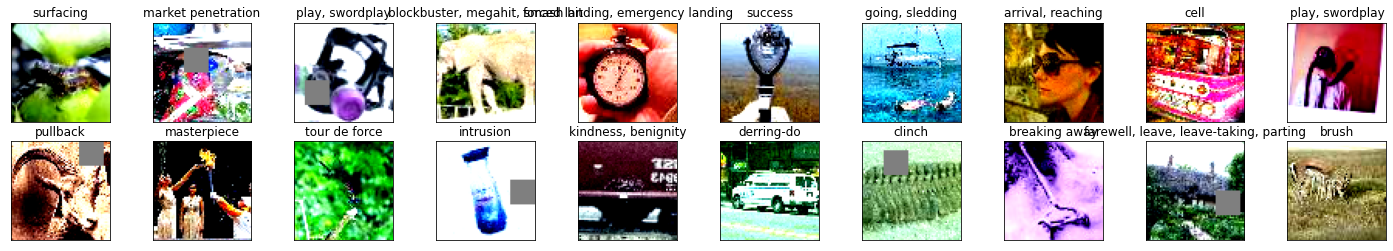

In [0]:
data_iterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(data_iterator, classes=classes)

In [0]:
#import os
#os.chdir('/content/gdrive/My Drive')

In [0]:
!pip install torchsummary
from torchsummary import summary
model = Resnet18_TinyImageNet.ResNet_18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 50
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.0012

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=test_loader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)                  
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

  0%|          | 0/301 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 4.930710315704346 Batch Id = 300 Train Acc = 2.74 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Test Accuracy: 5.26, LR : 0.001200

EPOCH: 1


Train Loss = 4.541747093200684 Batch Id = 300 Train Acc = 5.66 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Test Accuracy: 7.07, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.018906, Latest Loss: 0.017928, Delta: 0.000978

EPOCH: 2


Train Loss = 4.4402008056640625 Batch Id = 300 Train Acc = 8.55 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Test Accuracy: 10.59, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.017928, Latest Loss: 0.016767, Delta: 0.001162

EPOCH: 3


Train Loss = 4.036300182342529 Batch Id = 300 Train Acc = 11.28 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Test Accuracy: 13.50, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.016767, Latest Loss: 0.015882, Delta: 0.000885

EPOCH: 4


Train Loss = 3.933178424835205 Batch Id = 300 Train Acc = 13.53 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Test Accuracy: 15.85, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.015882, Latest Loss: 0.015238, Delta: 0.000644

EPOCH: 5


Train Loss = 3.850534439086914 Batch Id = 300 Train Acc = 15.69 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Test Accuracy: 17.20, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.015238, Latest Loss: 0.014778, Delta: 0.000460

EPOCH: 6


Train Loss = 3.5840232372283936 Batch Id = 300 Train Acc = 17.65 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Test Accuracy: 16.88, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.014778, Latest Loss: 0.014949, Delta: -0.000171

EPOCH: 7


Train Loss = 3.6218056678771973 Batch Id = 300 Train Acc = 19.74 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Test Accuracy: 19.69, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.014949, Latest Loss: 0.014086, Delta: 0.000863

EPOCH: 8


Train Loss = 3.484286069869995 Batch Id = 300 Train Acc = 21.77 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Test Accuracy: 21.62, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.014086, Latest Loss: 0.013661, Delta: 0.000425

EPOCH: 9


Train Loss = 3.4553544521331787 Batch Id = 300 Train Acc = 23.39 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Test Accuracy: 23.72, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.013661, Latest Loss: 0.013158, Delta: 0.000503

EPOCH: 10


Train Loss = 3.1791939735412598 Batch Id = 300 Train Acc = 25.22 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Test Accuracy: 25.58, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.013158, Latest Loss: 0.012768, Delta: 0.000391

EPOCH: 11


Train Loss = 3.200525999069214 Batch Id = 300 Train Acc = 26.87 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Test Accuracy: 26.53, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.012768, Latest Loss: 0.012534, Delta: 0.000233

EPOCH: 12


Train Loss = 3.08126163482666 Batch Id = 300 Train Acc = 28.16 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Test Accuracy: 27.50, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.012534, Latest Loss: 0.012339, Delta: 0.000195

EPOCH: 13


Train Loss = 2.980746030807495 Batch Id = 300 Train Acc = 29.72 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Test Accuracy: 28.75, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.012339, Latest Loss: 0.012033, Delta: 0.000306

EPOCH: 14


Train Loss = 3.0544590950012207 Batch Id = 300 Train Acc = 31.04 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Test Accuracy: 28.47, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.012033, Latest Loss: 0.012018, Delta: 0.000014

EPOCH: 15


Train Loss = 2.981041669845581 Batch Id = 300 Train Acc = 32.49 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Test Accuracy: 30.74, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.012018, Latest Loss: 0.011672, Delta: 0.000346

EPOCH: 16


Train Loss = 2.8436248302459717 Batch Id = 300 Train Acc = 33.58 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Test Accuracy: 32.88, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.011672, Latest Loss: 0.011228, Delta: 0.000445

EPOCH: 17


Train Loss = 2.7467339038848877 Batch Id = 300 Train Acc = 34.99 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Test Accuracy: 32.44, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.011228, Latest Loss: 0.011246, Delta: -0.000018

EPOCH: 18


Train Loss = 2.501553773880005 Batch Id = 300 Train Acc = 36.08 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Test Accuracy: 33.10, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.011246, Latest Loss: 0.011161, Delta: 0.000085

EPOCH: 19


Train Loss = 2.6971817016601562 Batch Id = 300 Train Acc = 37.25 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Test Accuracy: 33.90, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.011161, Latest Loss: 0.011025, Delta: 0.000136

EPOCH: 20


Train Loss = 2.9717793464660645 Batch Id = 300 Train Acc = 38.38 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Test Accuracy: 33.35, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.011025, Latest Loss: 0.011077, Delta: -0.000052

EPOCH: 21


Train Loss = 2.6824469566345215 Batch Id = 300 Train Acc = 39.26 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Test Accuracy: 35.83, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.011077, Latest Loss: 0.010618, Delta: 0.000459

EPOCH: 22


Train Loss = 2.605684995651245 Batch Id = 300 Train Acc = 40.46 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Test Accuracy: 34.06, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.010618, Latest Loss: 0.011047, Delta: -0.000429

EPOCH: 23


Train Loss = 2.3013226985931396 Batch Id = 300 Train Acc = 41.54 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Test Accuracy: 38.06, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.011047, Latest Loss: 0.010179, Delta: 0.000868

EPOCH: 24


Train Loss = 2.341111898422241 Batch Id = 300 Train Acc = 42.21 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Test Accuracy: 37.37, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.010179, Latest Loss: 0.010323, Delta: -0.000144

EPOCH: 25


Train Loss = 2.4335105419158936 Batch Id = 300 Train Acc = 43.49 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Test Accuracy: 37.85, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.010323, Latest Loss: 0.010250, Delta: 0.000073

EPOCH: 26


Train Loss = 2.29327654838562 Batch Id = 300 Train Acc = 44.36 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Test Accuracy: 38.43, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.010250, Latest Loss: 0.010073, Delta: 0.000177

EPOCH: 27


Train Loss = 2.059302806854248 Batch Id = 300 Train Acc = 45.39 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Test Accuracy: 39.42, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.010073, Latest Loss: 0.009953, Delta: 0.000121

EPOCH: 28


Train Loss = 2.0901904106140137 Batch Id = 300 Train Acc = 45.92 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Test Accuracy: 38.26, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.009953, Latest Loss: 0.010222, Delta: -0.000269

EPOCH: 29


Train Loss = 2.324617385864258 Batch Id = 300 Train Acc = 46.96 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Test Accuracy: 41.28, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.010222, Latest Loss: 0.009552, Delta: 0.000670

EPOCH: 30


Train Loss = 2.0930469036102295 Batch Id = 300 Train Acc = 47.64 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Test Accuracy: 40.42, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.009552, Latest Loss: 0.009740, Delta: -0.000188

EPOCH: 31


Train Loss = 1.9563541412353516 Batch Id = 300 Train Acc = 48.54 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Test Accuracy: 40.71, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.009740, Latest Loss: 0.009777, Delta: -0.000038

EPOCH: 32


Train Loss = 2.4291927814483643 Batch Id = 300 Train Acc = 49.33 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Test Accuracy: 42.44, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009777, Latest Loss: 0.009361, Delta: 0.000417

EPOCH: 33


Train Loss = 2.031761646270752 Batch Id = 300 Train Acc = 50.21 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Test Accuracy: 42.68, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009361, Latest Loss: 0.009271, Delta: 0.000090

EPOCH: 34


Train Loss = 2.036717653274536 Batch Id = 300 Train Acc = 50.86 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Test Accuracy: 43.73, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009271, Latest Loss: 0.009112, Delta: 0.000158

EPOCH: 35


Train Loss = 1.9806208610534668 Batch Id = 300 Train Acc = 51.63 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Test Accuracy: 41.63, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.009112, Latest Loss: 0.009607, Delta: -0.000495

EPOCH: 36


Train Loss = 1.8784524202346802 Batch Id = 300 Train Acc = 52.51 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Test Accuracy: 44.94, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009607, Latest Loss: 0.008927, Delta: 0.000680

EPOCH: 37


Train Loss = 1.7654390335083008 Batch Id = 300 Train Acc = 53.19 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Test Accuracy: 44.16, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.008927, Latest Loss: 0.009062, Delta: -0.000136

EPOCH: 38


Train Loss = 2.0915942192077637 Batch Id = 300 Train Acc = 54.10 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Test Accuracy: 42.63, LR : 0.001200
Test Loss -> Increasing, Prev Loss: 0.009062, Latest Loss: 0.009373, Delta: -0.000311

EPOCH: 39


Train Loss = 1.8493229150772095 Batch Id = 300 Train Acc = 54.98 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Test Accuracy: 43.44, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009373, Latest Loss: 0.009230, Delta: 0.000144

EPOCH: 40


Train Loss = 1.853676676750183 Batch Id = 300 Train Acc = 55.41 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Test Accuracy: 43.60, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009230, Latest Loss: 0.009206, Delta: 0.000024

EPOCH: 41


Train Loss = 1.8016914129257202 Batch Id = 300 Train Acc = 56.45 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    42: reducing learning rate of group 0 to 1.2000e-04.

Test set: Average loss: 0.0090, Test Accuracy: 44.73, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.009206, Latest Loss: 0.008988, Delta: 0.000218

EPOCH: 42


Train Loss = 1.6544485092163086 Batch Id = 300 Train Acc = 61.14 LR =0.000120: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 49.74, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.008988, Latest Loss: 0.008024, Delta: 0.000964

EPOCH: 43


Train Loss = 1.5435277223587036 Batch Id = 300 Train Acc = 62.27 LR =0.000120: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.10, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.008024, Latest Loss: 0.007969, Delta: 0.000055

EPOCH: 44


Train Loss = 1.7148499488830566 Batch Id = 300 Train Acc = 62.50 LR =0.000120: 100%|██████████| 301/301 [02:49<00:00,  1.78it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.20, LR : 0.000120
Test Loss -> Increasing, Prev Loss: 0.007969, Latest Loss: 0.007976, Delta: -0.000007

EPOCH: 45


Train Loss = 1.4639787673950195 Batch Id = 300 Train Acc = 62.98 LR =0.000120: 100%|██████████| 301/301 [02:44<00:00,  1.83it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.12, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.007976, Latest Loss: 0.007973, Delta: 0.000004

EPOCH: 46


Train Loss = 1.6788358688354492 Batch Id = 300 Train Acc = 63.05 LR =0.000120: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.18, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.007973, Latest Loss: 0.007964, Delta: 0.000008

EPOCH: 47


Train Loss = 1.6816354990005493 Batch Id = 300 Train Acc = 63.31 LR =0.000120: 100%|██████████| 301/301 [02:44<00:00,  1.83it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.25, LR : 0.000120
Test Loss -> Increasing, Prev Loss: 0.007964, Latest Loss: 0.007972, Delta: -0.000008

EPOCH: 48


Train Loss = 1.606698989868164 Batch Id = 300 Train Acc = 63.43 LR =0.000120: 100%|██████████| 301/301 [02:44<00:00,  1.83it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Test Accuracy: 50.26, LR : 0.000120
Test Loss -> Increasing, Prev Loss: 0.007972, Latest Loss: 0.007986, Delta: -0.000014

EPOCH: 49


Train Loss = 1.6861646175384521 Batch Id = 300 Train Acc = 63.45 LR =0.000120: 100%|██████████| 301/301 [02:44<00:00,  1.83it/s]



Test set: Average loss: 0.0080, Test Accuracy: 50.30, LR : 0.000120
Test Loss -> Decreasing, Prev Loss: 0.007986, Latest Loss: 0.007954, Delta: 0.000032


#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

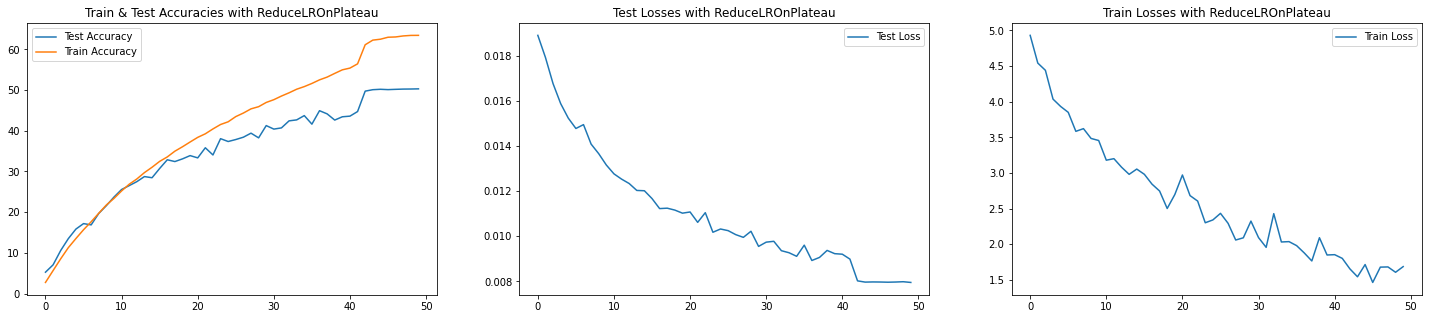

In [0]:
figure = plt.figure(figsize=(25,5))
#labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")   